In [ ]:
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
import nltk
from nltk.tokenize import word_tokenize
nltk.download('punkt')
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


### Preparing Data

We provided you with a dataset that is an extract from the bible. It is a parallel dataset for the Cherokee and English language. Cherokee will be the source language, and English the target language. 

I put the data in a data.zip, which we will open and process now. 

**LOCAL NOTEBOOK:**
If you are opening this in a jupyter notebook, just make sure the zip is in the same directory. Skip the following cells till the next text block.

**GOOGLE COLAB:**
Are you working in a google colab, you need to give acces to google drive where you can put the zip with data. Run the following cells and follow the instructions.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# MAKE SURE TO CHANGE THE PATH IN YOUR GOOGLE DRIVE TO THE DATAFILE. 
# !cp drive/MyDrive/[path to data in your personal google drive]/data.zip .
# !cp 'drive/MyDrive/KULEUVEN/teaching/NLP/NLP 2021-2022/Exercises/General_Track/exercise5_machine_translation/data.zip' .
!cp 'drive/MyDrive/1 PhD/Teaching/NLP TA/NLP 2021-2022/Exercises/General_Track/exercise5_machine_translation/data.zip' .

cp: cannot stat 'drive/MyDrive/1 PhD/Teaching/NLP TA/NLP 2021-2022/Exercises/General_Track/exercise5_machine_translation/data.zip': No such file or directory


Let us unzip the data.zip file and have a look at what some of the data looks like.

In [ ]:
!unzip data.zip
!ls -l chr_en_data

Archive:  data.zip
replace chr_en_data/dev.chr? [y]es, [n]o, [A]ll, [N]one, [r]ename: N
total 4516
-rw-r--r-- 1 root root  156015 Feb  2  2021 dev.chr
-rw-r--r-- 1 root root   98456 Feb  2  2021 dev.en
-rw-r--r-- 1 root root  157759 Feb  2  2021 test.chr
-rw-r--r-- 1 root root  100893 Feb  2  2021 test.en
-rw-r--r-- 1 root root     213 Dec  1 16:25 tiny_dev.chr
-rw-r--r-- 1 root root     115 Dec  1 16:25 tiny_dev.en
-rw-r--r-- 1 root root    2506 Dec  1 16:25 tiny_train.chr
-rw-r--r-- 1 root root    1683 Dec  1 16:25 tiny_train.en
-rw-r--r-- 1 root root 2497276 Feb  2  2021 train.chr
-rw-r--r-- 1 root root 1581843 Feb  2  2021 train.en


Okay, so we have a training, a development, and a test split. Let's look inside one of the files.

---
first english:

In [ ]:
with open('chr_en_data/dev.en','r') as f:
    for i,l in enumerate(f):
        if i > 6:
            break
        print(l)

Paul, and Silvanus, and Timothy, unto the church of the Thessalonians in God our Father and the Lord Jesus Christ;

And when the multitudes heard it, they were astonished at his teaching.

After these things I saw another angel coming down out of heaven, having great authority; and the earth was lightened with his glory.

And this is the sign unto you: Ye shall find a babe wrapped in swaddling clothes, and lying in a manger.

He could hardly believe what he was seeing, and although he detested flies, he was sorry for this one.

And he entered into Jerusalem, into the temple; and when he had looked round about upon all things, it being now eventide, he went out unto Bethany with the twelve.

And for our relentless searching, two weeks of it, all we found was one old man, nearly blind and living alone, who said his name was Hog Meat and that he was nearly a hundred years old.



and cherokee:

In [ ]:
with open('chr_en_data/dev.chr','r') as f:
    for i,l in enumerate(f):
        if i > 6:
            break
        print(l)

ᏉᎳ, ᎠᎴ ᏌᏱᎳ, ᎠᎴ ᏗᎹᏗ, ᏫᏨᏲᏪᎳᏏ ᏗᏣᏁᎶᏗ ᎢᏣᏓᏡᎬ ᏕᏏᎶᏂᎦ ᎢᏤᎯ ᎤᏁᎳᏅᎯ ᎢᎩᏙᏓ ᎠᎴ ᎤᎬᏫᏳᎯ ᏥᏌ ᎦᎶᏁᏛ ᏕᏣᏁᎶᏛᎢ.

ᎤᏂᏣᏘᏃ ᎤᎾᏛᎦᏅ ᎤᏂᏍᏆᏂᎪᏒᎩ ᏄᏍᏛ ᏓᏕᏲᎲᏍᎬᎢ.

ᎾᏍᎩᏃ ᎯᎠ ᏄᎵᏍᏔᏂᏙᎸ ᏅᏩᏓᎴ ᏗᎧᎿᏩᏗᏙᎯ ᎥᏥᎪᎥᎩ ᎦᎸᎳᏗ ᏓᏳᏠᎠᏒᎩ, ᎤᏣᏘ ᎤᎵᏂᎩᏛ ᎨᏒᎩ; ᎾᏍᎩᏃ ᎤᏤᎵ ᎦᎸᏉᏗᏳ ᎨᏒ ᎡᎶᎯ ᎢᎦ ᎤᏘᏍᏔᏅᎩ.

ᎯᎠᏃ ᎾᏍᎩ ᎢᏣᏙᎯᎱᎯᏍᏙ ᎨᏎᏍᏗ; Ꮣ ᏰᏥᏩᏛᎯ ᎠᏲᎵ ᎠᏥᏣᏄᎴᏍᏗ, ᏐᏈᎵ ᎤᎾᎵᏍᏓᏴᏗᏱ ᎦᏅᎨᏍᏗ.

ᎨᏍᏗ ᏳᏬᎯᏳᎮ ᏄᏍᏛ ᎠᎪᏩᏘᏍᎬ, ᎠᏎᏃ ᎤᏙᎯᏳ ᏕᎦᏁᎵᏍᎨ ᏛᎦ, ᎦᏙᎵᎨ ᏍᎩᎾᎾ.

ᏥᏌᏃ ᏣᎷᏏᎵᎻ ᏭᏴᎴᎢ, ᎠᎴ ᎤᏔᏅ-ᏗᎦᎳᏫᎢᏍᏗᏱ ᏭᏴᎴᎢ; ᎿᏉᏃ ᎬᏩᏚᏫᏛ ᏚᎧᎿᏂᏙᎸ ᏂᎦᏛ ᏧᏓᎴᏅᏛ ᏚᎧᎿᏅ, ᎠᎴ ᎿᏉ ᎤᏒᎯᏴᏱ ᎨᏎᎢ, ᎤᏄᎪᏤ ᏇᏗᏂᏱ ᏭᎶᏎ ᎠᏁᎮ ᏔᎳᏚ ᎢᏯᏂᏛ.

ᏔᎵ ᎢᏳᎾᏙᏓᏆᏍᏗ ᏙᏥᎭᏲᎲ, ᏐᏉ ᎣᏥᏩᏛᎲ ᎤᏛᏐᏅ ᎾᎥᏂ ᏗᎨᏫ ᏃᎴ ᎤᏩᏌ ᎦᏂᎩᎸ, ᏏᏆ ᎭᏫᏯ ᏧᏙᎢᏓ ᎤᏛᏅ ᏃᎴ ᎾᎥᏂ ᏍᎪᎯᏍᏆ ᎢᏳᏕᏘᏴᏓ.



In [ ]:
for lan in ['chr','en']:
  for split in ['train','test','dev']:
    f = f'chr_en_data/{split}.{lan}'
    num_lines = sum(1 for line in open(f,'r'))
    print(f'File {f} has {num_lines} lines')

File chr_en_data/train.chr has 14855 lines
File chr_en_data/test.chr has 1000 lines
File chr_en_data/dev.chr has 1000 lines
File chr_en_data/train.en has 14855 lines
File chr_en_data/test.en has 1000 lines
File chr_en_data/dev.en has 1000 lines


### Tiny dataset

To get quick visualisations, we simplify the dataset by making a tiny one. 
The 'head' command extracts the first -n = 20 lines from the file.

In [ ]:
!head -n 20 chr_en_data/train.en > chr_en_data/tiny_train.en
!head -n 20 chr_en_data/train.chr > chr_en_data/tiny_train.chr
!head -n 1 chr_en_data/dev.en > chr_en_data/tiny_dev.en
!head -n 1 chr_en_data/dev.chr > chr_en_data/tiny_dev.chr

In [ ]:
!ls -l chr_en_data/
!cat chr_en_data/tiny_dev.chr

total 4516
-rw-r--r-- 1 root root  156015 Feb  2  2021 dev.chr
-rw-r--r-- 1 root root   98456 Feb  2  2021 dev.en
-rw-r--r-- 1 root root  157759 Feb  2  2021 test.chr
-rw-r--r-- 1 root root  100893 Feb  2  2021 test.en
-rw-r--r-- 1 root root     213 Dec  1 16:41 tiny_dev.chr
-rw-r--r-- 1 root root     115 Dec  1 16:41 tiny_dev.en
-rw-r--r-- 1 root root    2506 Dec  1 16:41 tiny_train.chr
-rw-r--r-- 1 root root    1683 Dec  1 16:41 tiny_train.en
-rw-r--r-- 1 root root 2497276 Feb  2  2021 train.chr
-rw-r--r-- 1 root root 1581843 Feb  2  2021 train.en
ᏉᎳ, ᎠᎴ ᏌᏱᎳ, ᎠᎴ ᏗᎹᏗ, ᏫᏨᏲᏪᎳᏏ ᏗᏣᏁᎶᏗ ᎢᏣᏓᏡᎬ ᏕᏏᎶᏂᎦ ᎢᏤᎯ ᎤᏁᎳᏅᎯ ᎢᎩᏙᏓ ᎠᎴ ᎤᎬᏫᏳᎯ ᏥᏌ ᎦᎶᏁᏛ ᏕᏣᏁᎶᏛᎢ.


# Preparing the data

We need to make sure we have a dataset and a dataloader, so we can iterate over the data.

We also need to define the vocabularies.

### Language vocab

We create a very simplistic vocabulary. We just add all the words in our dataset. 

Normally, we make sure there is an Unkown token, and only keep the K most common tokens.  We can choose K depending on our data.

In [ ]:
class SimpleVocab:
    def __init__(self, name):
        self.name = name
        self.word2index = {}
        self.word2count = {}
        self.index2word = {0: "SOS", 1: "EOS"}
        self.sos_idx = 0
        self.eos_idx = 1
        self.n_words = 2  # Count SOS and EOS

    def add_sentence(self, sentence):
        for word in word_tokenize(sentence):
            self.add_word(word)

    def add_word(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1

Now lets quickly read the tiny datasets into our vocabulary. To avoid unknown tokens, we also add the dev set to our tiny vocabulary. 

**Note: Usually you wouldn't do this!**

In [ ]:
chr_vocab = SimpleVocab('chr')
en_vocab = SimpleVocab('en')
# first the cherokee data
with open('chr_en_data/tiny_train.chr','r') as f:
    for sent in f:
        chr_vocab.add_sentence(sent)
with open('chr_en_data/tiny_dev.chr','r') as f:
    for sent in f:
        chr_vocab.add_sentence(sent)
# now the english data
with open('chr_en_data/tiny_train.en','r') as f:
    for sent in f:
        en_vocab.add_sentence(sent)
with open('chr_en_data/tiny_dev.en','r') as f:
    for sent in f:
        en_vocab.add_sentence(sent)

print(en_vocab.index2word)
print(chr_vocab.index2word)

{0: 'SOS', 1: 'EOS', 2: 'and', 3: 'by', 4: 'him', 5: 'every', 6: 'one', 7: 'that', 8: 'believeth', 9: 'is', 10: 'justified', 11: 'from', 12: 'all', 13: 'things', 14: ',', 15: 'which', 16: 'ye', 17: 'could', 18: 'not', 19: 'be', 20: 'the', 21: 'law', 22: 'of', 23: 'Moses', 24: '.', 25: 'When', 26: 'he', 27: 'was', 28: 'done', 29: 'with', 30: 'body', 31: 'held', 32: 'head', 33: 'in', 34: 'his', 35: 'mouth', 36: 'sucked', 37: 'until', 38: 'it', 39: 'no', 40: 'more', 41: 'flavor', 42: 'than', 43: 'own', 44: 'spit', 45: 'But', 46: 'each', 47: 'order', 48: ':', 49: 'Christ', 50: 'firstfruits', 51: ';', 52: 'then', 53: 'they', 54: 'are', 55: '’', 56: 's', 57: 'at', 58: 'coming', 59: 'His', 60: 'a', 61: 'strange', 62: 'homecoming', 63: 'So', 64: 'chief', 65: 'captain', 66: 'let', 67: 'young', 68: 'man', 69: 'go', 70: 'charging', 71: 'Tell', 72: 'thou', 73: 'hast', 74: 'signified', 75: 'these', 76: 'to', 77: 'me', 78: 'He', 79: 'picked', 80: 'letter', 81: 'up', 82: 'again', 83: 'studied', 84: '

In [ ]:
class MyDataset(Dataset):
    def __init__(self, source_sents, target_sents, source_vocab, target_vocab):
        self.source = source_sents
        self.target = target_sents
        self.source_vocab = source_vocab
        self.target_vocab = target_vocab

    def __len__(self):
        return len(self.target)

    def __getitem__(self, index):
        source_ids = [self.source_vocab.word2index[x] for x in self.source[index]]
        target_ids = [self.target_vocab.word2index[x] for x in self.target[index]]

        # lets make sure we always add the start and end token tot the sequences
        source_ids = [self.source_vocab.sos_idx] + source_ids + [self.source_vocab.eos_idx]
        target_ids = [self.target_vocab.sos_idx] + target_ids + [self.target_vocab.eos_idx]
        return torch.tensor(source_ids), torch.tensor(target_ids)

Let us initialize our train and test dataset

In [ ]:
chr_train_sents = []
chr_test_sents = []
en_train_sents = []
en_test_sents = []

with open('chr_en_data/tiny_train.chr','r') as f:
    for sent in f:
        chr_train_sents.append(word_tokenize(sent))
with open('chr_en_data/tiny_dev.chr','r') as f:
    for sent in f:
        chr_test_sents.append(word_tokenize(sent))
with open('chr_en_data/tiny_train.en','r') as f:
    for sent in f:
        en_train_sents.append(word_tokenize(sent))
with open('chr_en_data/tiny_dev.en','r') as f:
    for sent in f:
        en_test_sents.append(word_tokenize(sent))

train_dataset = MyDataset(chr_train_sents, en_train_sents, chr_vocab, en_vocab)
test_dataset = MyDataset(chr_test_sents, en_test_sents, chr_vocab, en_vocab)

In [ ]:
len(train_dataset.source)

20

# Defining our model

First we define our RNN as a seperate module

In [ ]:
class MyRNNCell(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(MyRNNCell, self).__init__()
        self.hidden_size = hidden_size

        # first we define all our matrices and parameters
        self.weight_in = nn.Parameter(data=torch.zeros(input_size, hidden_size))
        self.weight_h = nn.Parameter(data=torch.zeros(hidden_size, hidden_size))
        self.bias = nn.Parameter(data=torch.zeros(hidden_size))

        # now we initialize the parameters with random values
        nn.init.uniform_(self.weight_in, -0.5, 0.5)
        nn.init.uniform_(self.weight_h, -0.5, 0.5)
        nn.init.uniform_(self.bias, -0.5, 0.5)

    def forward(self, input, hidden):
        # in the forward function we define our layers. 
        # for matrix multiplications you can use the @ operator
        # for transpose you can use tensor.T
        # make sure to add a sigmoid non linearity after the rnn step with torch.sigmoid()
        output = self.weight_in.T @ input + self.weight_h.T @ hidden + self.bias
        output = torch.sigmoid(output)
        return output

Then, we use this RNN module in both the encoder and the decoder.

In [ ]:
class MyRNNEncoder(nn.Module):
    def __init__(self, source_vocab_size, emb_size, hidden_size):
        super(MyRNNEncoder, self).__init__()
        self.hidden_size = hidden_size

        self.source_embedding = nn.Embedding(source_vocab_size, emb_size)
        self.rnn = MyRNNCell(emb_size, hidden_size)

    def forward(self, input_word, hidden):
        # performs one rnn_step
        emb = self.source_embedding(input_word)
        hidden = self.rnn(emb, hidden)
        return hidden
    
    def init_hidden(self):
        return torch.zeros((self.hidden_size),requires_grad=True)

In [ ]:
class MyRNNDecoder(nn.Module):
    def __init__(self, target_vocab_size, emb_size, hidden_size):
        super(MyRNNDecoder, self).__init__()
        self.hidden_size = hidden_size

        self.target_embedding = nn.Embedding(target_vocab_size, emb_size)
        self.rnn = MyRNNCell(emb_size, hidden_size)
        self.weight_out = nn.Parameter(data=torch.zeros(hidden_size, target_vocab_size))

        nn.init.uniform_(self.weight_out, -0.5, 0.5)

    def forward(self, input_word, hidden):
        # performs one rnn_step
        emb = self.target_embedding(input_word)
        hidden = self.rnn(emb, hidden)
        output = self.weight_out.T @ hidden
        return output, hidden

# Training and Evaluating

First we define the loss function (criterion), the optimizer, and some settings.

In [ ]:
hidden_size = 64
emb_size = 32
learning_rate = 0.1

rnn_encoder = MyRNNEncoder(chr_vocab.n_words, emb_size, hidden_size)
rnn_decoder = MyRNNDecoder(en_vocab.n_words, emb_size, hidden_size)

rnn_criterion = nn.CrossEntropyLoss()

params = list(rnn_encoder.parameters()) + list(rnn_decoder.parameters())
rnn_optimizer = torch.optim.SGD(params, lr=learning_rate)

print(rnn_encoder)
print(rnn_decoder)

MyRNNEncoder(
  (source_embedding): Embedding(173, 32)
  (rnn): MyRNNCell()
)
MyRNNDecoder(
  (target_embedding): Embedding(207, 32)
  (rnn): MyRNNCell()
)


In [ ]:
def train_model(num_epochs, encoder, decoder, criterion, optimizer):
    losses = []
    for epoch in range(num_epochs):
        
        for i, (source, target) in enumerate(train_dataset):
            hidden_state = encoder.init_hidden()
            # first we encode the entire sentence
            for word in source:
                hidden_state = encoder(word, hidden_state)
            
            # now we run the decoder
            outputs = torch.zeros(target.shape[-1], en_vocab.n_words)
            for t_idx, word in enumerate(target):
                output, hidden_state = decoder(word, hidden_state)
                outputs[t_idx] = output
            
            # let us compute the loss
            loss = criterion(outputs, target)
            losses.append(loss)

            # now we do the backprop
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
        print(
            f"Epoch [{epoch + 1}/{num_epochs}], "
            f"Step [{i + 1}/{len(train_dataset)}], "
            f"Loss: {loss.item():.4f}"
        )
    return losses

In [ ]:
rnn_losses = train_model(20, rnn_encoder, rnn_decoder, rnn_criterion, rnn_optimizer)

Epoch [1/20], Step [20/20], Loss: 4.5121
Epoch [2/20], Step [20/20], Loss: 3.6680
Epoch [3/20], Step [20/20], Loss: 3.2773
Epoch [4/20], Step [20/20], Loss: 2.9944
Epoch [5/20], Step [20/20], Loss: 2.7627
Epoch [6/20], Step [20/20], Loss: 2.5645
Epoch [7/20], Step [20/20], Loss: 2.3909
Epoch [8/20], Step [20/20], Loss: 2.2367
Epoch [9/20], Step [20/20], Loss: 2.0983
Epoch [10/20], Step [20/20], Loss: 1.9733
Epoch [11/20], Step [20/20], Loss: 1.8597
Epoch [12/20], Step [20/20], Loss: 1.7559
Epoch [13/20], Step [20/20], Loss: 1.6608
Epoch [14/20], Step [20/20], Loss: 1.5733
Epoch [15/20], Step [20/20], Loss: 1.4926
Epoch [16/20], Step [20/20], Loss: 1.4180
Epoch [17/20], Step [20/20], Loss: 1.3489
Epoch [18/20], Step [20/20], Loss: 1.2848
Epoch [19/20], Step [20/20], Loss: 1.2250
Epoch [20/20], Step [20/20], Loss: 1.1693


Now let us plot the losses:

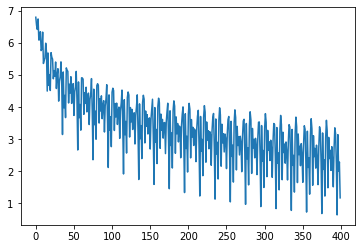

In [ ]:
import matplotlib.pyplot as plt
plt.plot(range(len(rnn_losses)), rnn_losses)

# Repeat with LSTM

In [ ]:
class MyLSTMCell(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(MyLSTMCell, self).__init__()
        self.hidden_size = hidden_size

        ## first we define all our matrices and parameters
        # in gate
        self.weight_in_in = nn.Parameter(data=torch.zeros(input_size, hidden_size))
        self.weight_in_h = nn.Parameter(data=torch.zeros(hidden_size, hidden_size))
        self.bias_in = nn.Parameter(data=torch.zeros(hidden_size))

        # forget gate
        self.weight_forget_in = nn.Parameter(data=torch.zeros(input_size, hidden_size))
        self.weight_forget_h = nn.Parameter(data=torch.zeros(hidden_size, hidden_size))
        self.bias_forget = nn.Parameter(data=torch.zeros(hidden_size))

        # cell gate
        self.weight_cell_in = nn.Parameter(data=torch.zeros(input_size, hidden_size))
        self.weight_cell_h = nn.Parameter(data=torch.zeros(hidden_size, hidden_size))
        self.bias_cell = nn.Parameter(data=torch.zeros(hidden_size))

        # out gate
        self.weight_out_in = nn.Parameter(data=torch.zeros(input_size, hidden_size))
        self.weight_out_h = nn.Parameter(data=torch.zeros(hidden_size, hidden_size))
        self.bias_out = nn.Parameter(data=torch.zeros(hidden_size))

        # now we initialize the parameters with random values
        nn.init.uniform_(self.weight_in_in, -0.5, 0.5)
        nn.init.uniform_(self.weight_in_h, -0.5, 0.5)
        nn.init.uniform_(self.bias_in, -0.5, 0.5)
        nn.init.uniform_(self.weight_forget_in, -0.5, 0.5)
        nn.init.uniform_(self.weight_forget_h, -0.5, 0.5)
        nn.init.uniform_(self.bias_forget, -0.5, 0.5)
        nn.init.uniform_(self.weight_cell_in, -0.5, 0.5)
        nn.init.uniform_(self.weight_cell_h, -0.5, 0.5)
        nn.init.uniform_(self.bias_cell, -0.5, 0.5)
        nn.init.uniform_(self.weight_out_in, -0.5, 0.5)
        nn.init.uniform_(self.weight_out_h, -0.5, 0.5)
        nn.init.uniform_(self.bias_out, -0.5, 0.5)
        
    def forward(self, input, state):
        # in the forward function we define our layers. 
        # for matrix multiplications you can use the @ operator
        # for transpose you can use tensor.T
        # make sure to add a sigmoid non linearity after every rnn step
        hx, cx = state

        ingate = self.weight_in_in.T @ input + self.weight_in_h.T @ hx + self.bias_in
        forgetgate = self.weight_forget_in.T @ input + self.weight_forget_h.T @ hx + self.bias_forget
        cellgate = self.weight_cell_in.T @ input + self.weight_cell_h.T @ hx + self.bias_cell
        outgate = self.weight_out_in.T @ input + self.weight_out_h.T @ hx + self.bias_out

        ingate = torch.sigmoid(ingate)
        forgetgate = torch.sigmoid(forgetgate)
        cellgate = torch.tanh(cellgate)
        outgate = torch.sigmoid(outgate)

        cy = (forgetgate * cx) + (ingate * cellgate)
        hy = outgate * torch.tanh(cy)

        return hy, cy

In [ ]:
class MyLSTMEncoder(nn.Module):
    def __init__(self, source_vocab_size, emb_size, hidden_size):
        super(MyLSTMEncoder, self).__init__()
        self.hidden_size = hidden_size

        self.source_embedding = nn.Embedding(source_vocab_size, emb_size)
        self.rnn = MyLSTMCell(emb_size, hidden_size)

    def forward(self, input_word, state):
        # performs one rnn_step
        emb = self.source_embedding(input_word)
        state = self.rnn(emb, state)
        return state
    
    def init_hidden(self):
        return (torch.zeros((self.hidden_size),requires_grad=True), 
                torch.zeros((self.hidden_size),requires_grad=True))

In [ ]:
class MyLSTMDecoder(nn.Module):
    def __init__(self, target_vocab_size, emb_size, hidden_size):
        super(MyLSTMDecoder, self).__init__()
        self.hidden_size = hidden_size

        self.target_embedding = nn.Embedding(target_vocab_size, emb_size)
        self.rnn = MyLSTMCell(emb_size, hidden_size)
        self.weight_out = nn.Parameter(data=torch.zeros(hidden_size, target_vocab_size))

        nn.init.uniform_(self.weight_out, -0.5, 0.5)

    def forward(self, input_word, state):
        # performs one rnn_step
        emb = self.target_embedding(input_word)
        hidden, cell = self.rnn(emb, state)
        output = self.weight_out.T @ hidden
        return output, (hidden, cell)

In [ ]:
hidden_size = 64
emb_size = 32
learning_rate = 0.1

lstm_encoder = MyLSTMEncoder(chr_vocab.n_words, emb_size, hidden_size)
lstm_decoder = MyLSTMDecoder(en_vocab.n_words, emb_size, hidden_size)

lstm_criterion = nn.CrossEntropyLoss()

params = list(lstm_encoder.parameters()) + list(lstm_decoder.parameters())
lstm_optimizer = torch.optim.SGD(params, lr=learning_rate)

print(lstm_encoder)
print(lstm_decoder)

MyLSTMEncoder(
  (source_embedding): Embedding(173, 32)
  (rnn): MyLSTMCell()
)
MyLSTMDecoder(
  (target_embedding): Embedding(207, 32)
  (rnn): MyLSTMCell()
)


In [ ]:
lstm_losses = train_model(20, lstm_encoder, lstm_decoder, lstm_criterion, lstm_optimizer)

Epoch [1/20], Step [20/20], Loss: 5.2291
Epoch [2/20], Step [20/20], Loss: 4.6348
Epoch [3/20], Step [20/20], Loss: 4.1328
Epoch [4/20], Step [20/20], Loss: 3.7076
Epoch [5/20], Step [20/20], Loss: 3.3440
Epoch [6/20], Step [20/20], Loss: 3.0398
Epoch [7/20], Step [20/20], Loss: 2.8023
Epoch [8/20], Step [20/20], Loss: 2.6211
Epoch [9/20], Step [20/20], Loss: 2.4757
Epoch [10/20], Step [20/20], Loss: 2.3505
Epoch [11/20], Step [20/20], Loss: 2.2367
Epoch [12/20], Step [20/20], Loss: 2.1295
Epoch [13/20], Step [20/20], Loss: 2.0266
Epoch [14/20], Step [20/20], Loss: 1.9268
Epoch [15/20], Step [20/20], Loss: 1.8296
Epoch [16/20], Step [20/20], Loss: 1.7349
Epoch [17/20], Step [20/20], Loss: 1.6427
Epoch [18/20], Step [20/20], Loss: 1.5533
Epoch [19/20], Step [20/20], Loss: 1.4669
Epoch [20/20], Step [20/20], Loss: 1.3840


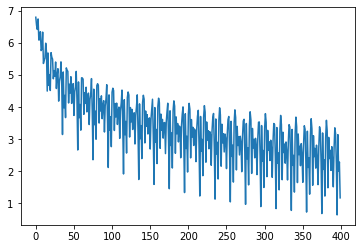

In [ ]:
plt.plot(range(len(rnn_losses)), rnn_losses)

### compare the predictions

we make a very simple script that takes one of the sentence from the train set and we compare the predictions. 

We don't use the test sentence, since with the tiny dataset we overfit extremely on our data. 

In [ ]:
def test_sentence(encoder, decoder, criterion, optimizer):
    with torch.no_grad():
        source, target = train_dataset[0]
        hidden_state = encoder.init_hidden()
        # first we encode the entire sentence
        for word in source:
            hidden_state = encoder(word, hidden_state)
        
        # now we run the decoder
        outputs = torch.zeros(target.shape[-1], en_vocab.n_words)
        for t_idx, word in enumerate(target):
            output, hidden_state = decoder(word, hidden_state)
            outputs[t_idx] = output
            
        # let us compute the loss
        loss = rnn_criterion(outputs, target)
    pred_ids = outputs.argmax(dim=-1).detach()
    sentence = [en_vocab.index2word[idx.item()] for idx in pred_ids]
    print("loss: {}".format(loss.detach().item()))
    print(sentence)


In [ ]:
test_sentence(rnn_encoder, rnn_decoder, rnn_criterion, rnn_optimizer)

loss: 2.9869914054870605
['SOS', 'and', 'over', 'the', 'Wilbur', 'the', 'that', ',', ',', 'of', 'of', 'they', 'things', ',', 'of', 'he', 'ye', 'The', 'EOS', 'be', 'of', 'over', 'the', 'EOS', 'of', 'to', '.', 'EOS']


In [ ]:
test_sentence(lstm_encoder, lstm_decoder, lstm_criterion, lstm_optimizer)

loss: 3.119859457015991
['SOS', 'and', 'some', 'him', 'unto', 'distribute', 'that', 'that', '.', 'EOS', '.', 'EOS', '”', ',', '.', 'the', 'ye', 'the', 'by', 'be', 'EOS', 'own', 'the', 'was', 'of', 'EOS', '.', 'EOS']
